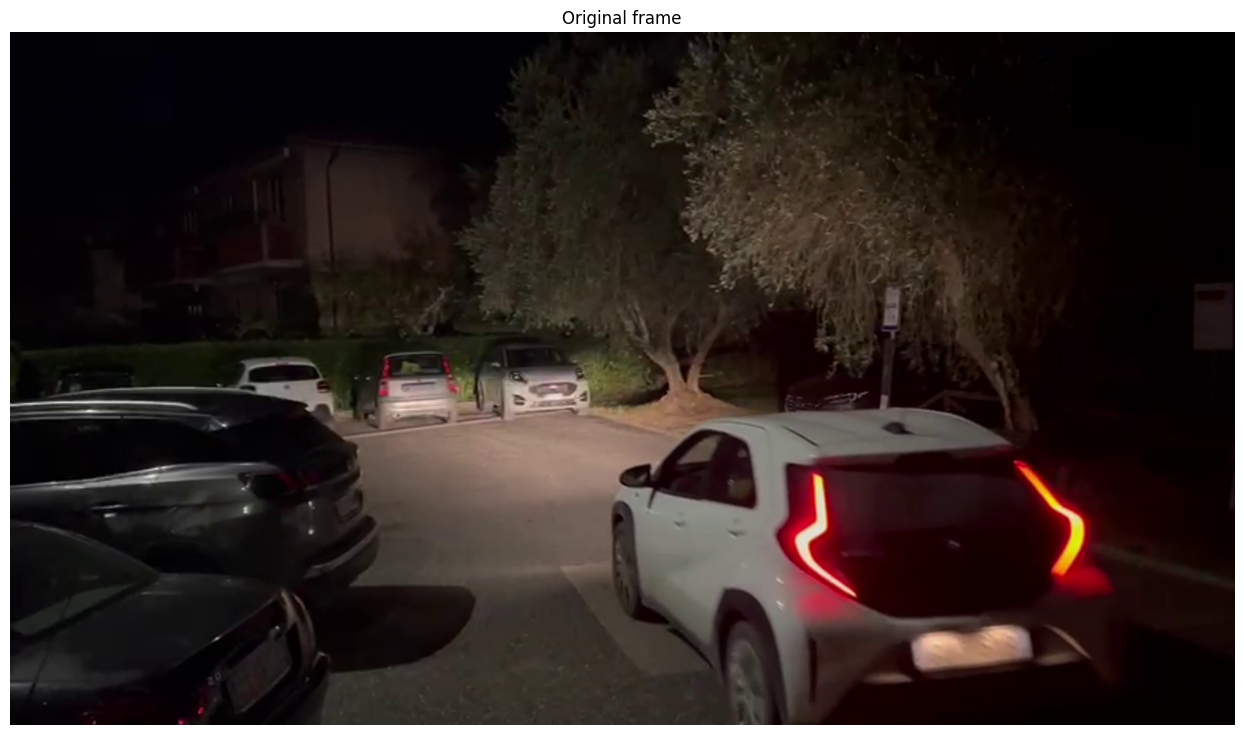

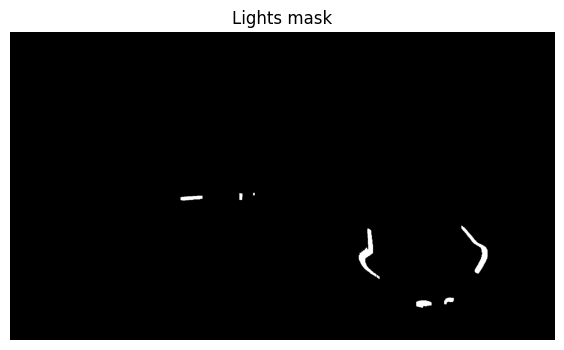

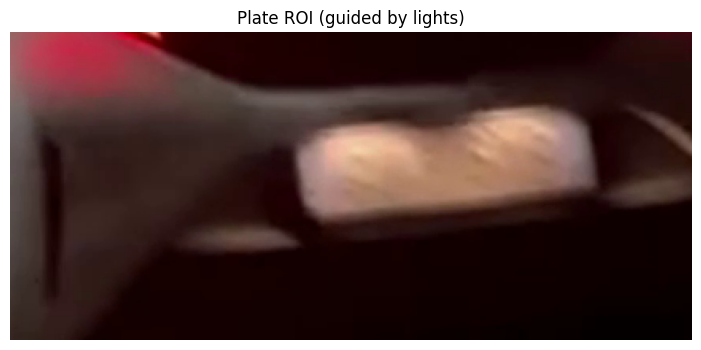

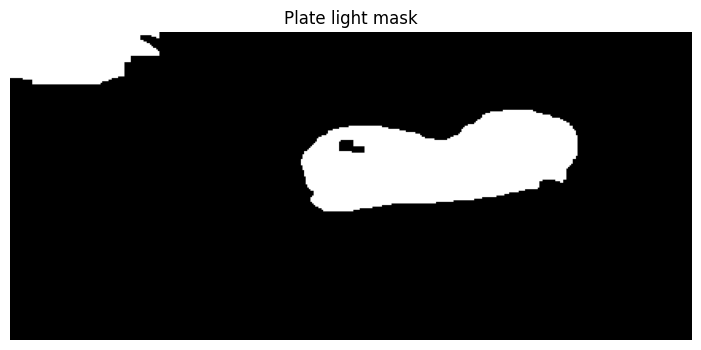

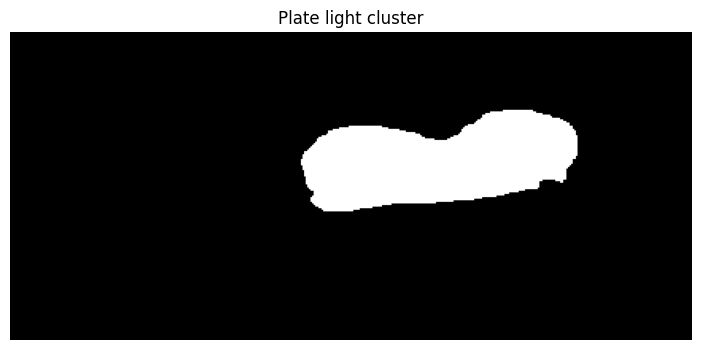

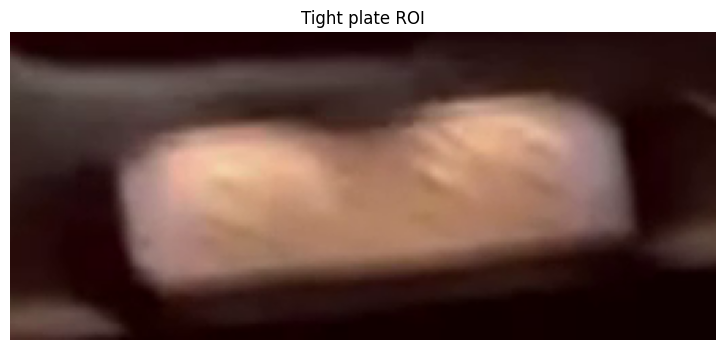

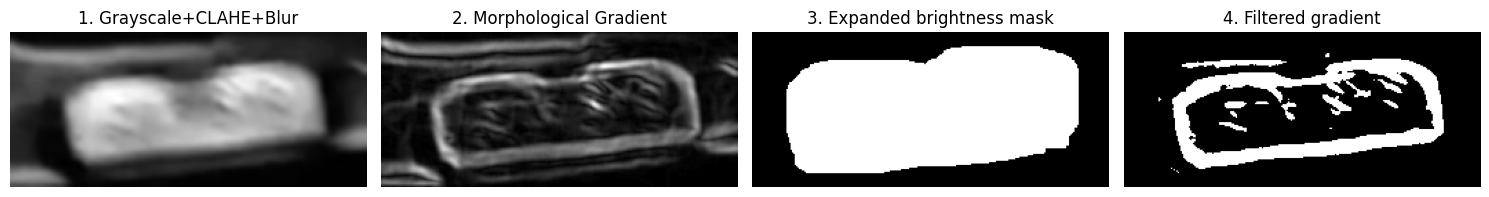

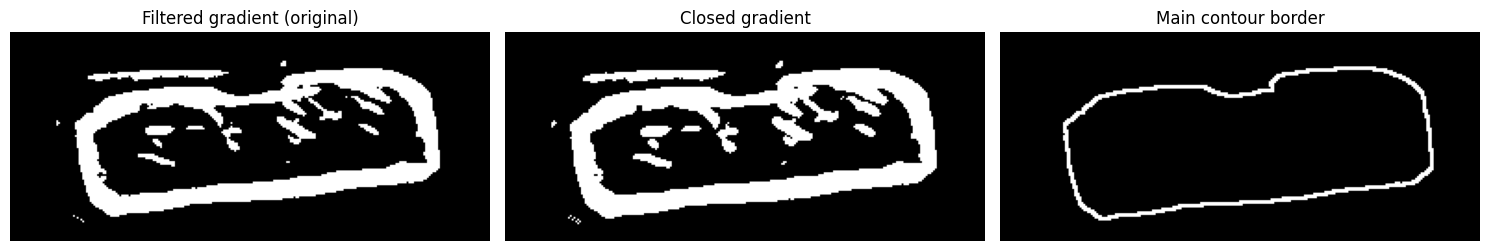

Candidates: top=60, bottom=35, left=17, right=14
After filtering: top=48, bottom=23, left=13, right=10


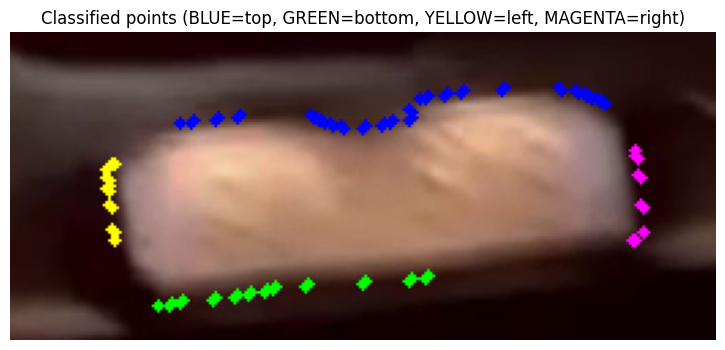

Lines computed: top=True, bottom=True, left=True, right=True

Plate corners: {'TL': (35, 37), 'TR': (229, 21), 'BL': (38, 100), 'BR': (230, 80)}


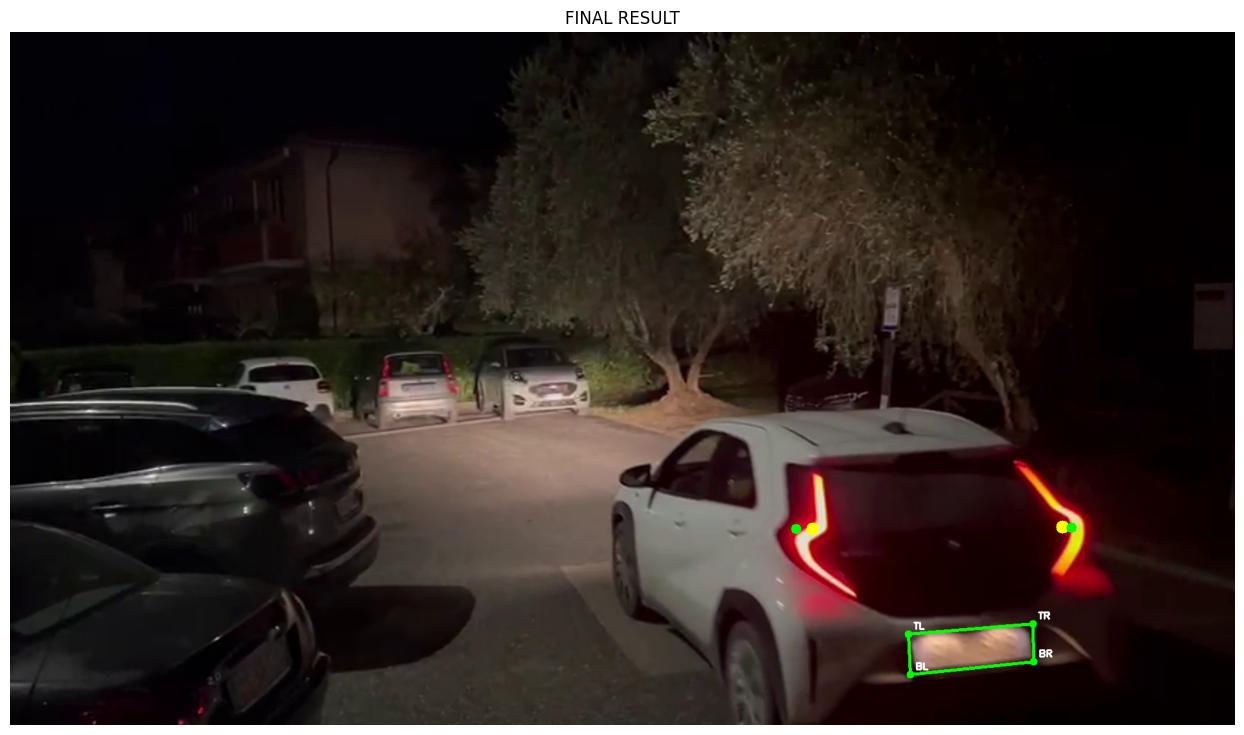


DETECTION COMPLETE
Lights: [(1250, 774), (1639, 771)]
Extremes: SX=(1224, 774), DX=(1653, 772)
Plate corners:
  TL: (1399,938)
  TR: (1593,922)
  BL: (1402,1001)
  BR: (1594,981)


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# =========================
# CONFIGURATION
# =========================
VIDEO_DIR = '/app/data/videos/input/'

# LIGHTS
V_LOWER = 210
MAX_Y_RATIO = 0.80
MIN_VERTICAL_RATIO = 1.2
MIN_CONTOUR_AREA_RATIO = 0.00015
MIN_CLUSTER_AREA_RATIO = 0.00015
Y_TOLERANCE = 5

# PLATE
V_PLATE_LOW  = 150
V_PLATE_HIGH = 240

# =========================
# VIDEO LOADING
# =========================
videos = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4','.avi','.mov'))]
VIDEO_PATH = os.path.join(VIDEO_DIR, videos[0])

cap = cv2.VideoCapture(VIDEO_PATH)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count//2 - 30)
ret, frame = cap.read()
cap.release()

# =========================
# ORIGINAL FRAME
# =========================
plt.figure(figsize=(16,9))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Original frame")
plt.axis("off")
plt.show()

# =========================
# LIGHTS MASK
# =========================
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
V = hsv[:,:,2]

mask = cv2.inRange(V, V_LOWER, 255)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,9))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(16,4))
plt.imshow(mask, cmap='gray')
plt.title("Lights mask")
plt.axis("off")
plt.show()

# =========================
# LIGHT CONTOURS
# =========================
contours,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
MIN_AREA = MIN_CONTOUR_AREA_RATIO * width * height
MAX_Y = int(height * MAX_Y_RATIO)

candidates = []
for c in contours:
    if cv2.contourArea(c) < MIN_AREA:
        continue
    x,y,w,h = cv2.boundingRect(c)
    if y > MAX_Y:
        continue
    if w/h > 1.0:
        continue
    if h/w < MIN_VERTICAL_RATIO:
        continue

    M = cv2.moments(c)
    if M['m00'] == 0:
        continue
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    candidates.append((c,cx,cy))

candidates = sorted(candidates, key=lambda p:p[1])
mid = len(candidates)//2
clusters = [candidates[:mid], candidates[mid:]]

# =========================
# LIGHT CENTERS
# =========================
fari = []
for cluster in clusters:
    xs,ys,a = [],[],[]
    for c,cx,cy in cluster:
        ar = cv2.contourArea(c)
        xs.append(cx*ar)
        ys.append(cy*ar)
        a.append(ar)
    fari.append((int(sum(xs)/sum(a)), int(sum(ys)/sum(a))))

# =========================
# LIGHT EXTREME POINTS
# =========================
extremes = {}
for idx, cluster in enumerate(clusters):
    y_mid = int(np.mean([cy for _,_,cy in cluster]))
    pts = []
    for c,_,_ in cluster:
        for px,py in c[:,0,:]:
            if abs(py - y_mid) <= Y_TOLERANCE:
                pts.append((px,py))
    if idx == 0:
        extremes['SX'] = min(pts, key=lambda p:p[0])
    else:
        extremes['DX'] = max(pts, key=lambda p:p[0])

# =========================
# PLATE ROI GUIDED BY LIGHTS
# =========================
fari_bottom_y = []
for cluster in clusters:
    ys = []
    for c,_,_ in cluster:
        ys.extend(c[:,0,1])
    fari_bottom_y.append(max(ys))

y_base = max(fari_bottom_y)
x1 = extremes['SX'][0]
x2 = extremes['DX'][0]

y1 = min(y_base + 20, height-1)
y2 = min(y1 + int(0.18 * height), height)

roi = frame[y1:y2, x1:x2]

plt.figure(figsize=(10,4))
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.title("Plate ROI (guided by lights)")
plt.axis("off")
plt.show()

# =========================
# PLATE BRIGHTNESS MASK
# =========================
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
V_roi = hsv_roi[:,:,2]

mask_plate = cv2.inRange(V_roi, V_PLATE_LOW, V_PLATE_HIGH)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,3))
mask_plate = cv2.morphologyEx(mask_plate, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(10,4))
plt.imshow(mask_plate, cmap='gray')
plt.title("Plate light mask")
plt.axis("off")
plt.show()

# =========================
# PLATE LIGHT CLUSTER
# =========================
contours,_ = cv2.findContours(mask_plate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest = max(contours, key=cv2.contourArea)

mask_cluster = np.zeros_like(mask_plate)
cv2.drawContours(mask_cluster, [largest], -1, 255, -1)

plt.figure(figsize=(10,4))
plt.imshow(mask_cluster, cmap='gray')
plt.title("Plate light cluster")
plt.axis("off")
plt.show()

# =========================
# TIGHT PLATE ROI EXTRACTION
# =========================
ys, xs = np.where(mask_cluster > 0)

x_min, x_max = xs.min(), xs.max()
y_min, y_max = ys.min(), ys.max()

pad_x = int(0.25 * (x_max - x_min))
pad_y = int(0.40 * (y_max - y_min))

roi_x_min = max(0, x_min - pad_x)
roi_x_max = min(roi.shape[1], x_max + pad_x)
roi_y_min = max(0, y_min - pad_y)
roi_y_max = min(roi.shape[0], y_max + pad_y)

roi_plate = roi[roi_y_min:roi_y_max, roi_x_min:roi_x_max]

plt.figure(figsize=(10,4))
plt.imshow(cv2.cvtColor(roi_plate, cv2.COLOR_BGR2RGB))
plt.title("Tight plate ROI")
plt.axis("off")
plt.show()

# =========================
# ADVANCED PRE-PROCESSING
# =========================
gray_plate = cv2.cvtColor(roi_plate, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray_plate = clahe.apply(gray_plate)
gray_plate = cv2.GaussianBlur(gray_plate, (7,7), 0)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
gradient = cv2.morphologyEx(gray_plate, cv2.MORPH_GRADIENT, kernel)

plt.figure(figsize=(15,4))
plt.subplot(141)
plt.imshow(gray_plate, cmap='gray')
plt.title("1. Grayscale+CLAHE+Blur")
plt.axis("off")

plt.subplot(142)
plt.imshow(gradient, cmap='gray')
plt.title("2. Morphological Gradient")
plt.axis("off")

# =========================
# BRIGHTNESS MASK FILTER
# =========================
hsv_plate = cv2.cvtColor(roi_plate, cv2.COLOR_BGR2HSV)
V_plate = hsv_plate[:,:,2]
mask_light = cv2.inRange(V_plate, V_PLATE_LOW, V_PLATE_HIGH)

# Expand mask to also capture edges
kernel_expand = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 15))
mask_light_expanded = cv2.dilate(mask_light, kernel_expand, iterations=2)

# Binarize gradient and filter it with the mask
_, gradient_binary = cv2.threshold(gradient, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
gradient_filtered = cv2.bitwise_and(gradient_binary, mask_light_expanded)

plt.subplot(143)
plt.imshow(mask_light_expanded, cmap='gray')
plt.title("3. Expanded brightness mask")
plt.axis("off")

plt.subplot(144)
plt.imshow(gradient_filtered, cmap='gray')
plt.title("4. Filtered gradient")
plt.axis("off")
plt.tight_layout()
plt.show()

# =========================
# MORPHOLOGICAL CLOSING BEFORE HOUGH
# =========================
# Close gaps in gradient to obtain continuous lines
kernel_close_h = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))  # horizontal
kernel_close_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))  # vertical

gradient_closed_h = cv2.morphologyEx(gradient_filtered, cv2.MORPH_CLOSE, kernel_close_h)
gradient_closed_v = cv2.morphologyEx(gradient_filtered, cv2.MORPH_CLOSE, kernel_close_v)
gradient_closed = cv2.bitwise_or(gradient_closed_h, gradient_closed_v)

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(gradient_filtered, cmap='gray')
plt.title("Filtered gradient (original)")
plt.axis("off")

plt.subplot(132)
plt.imshow(gradient_closed, cmap='gray')
plt.title("Closed gradient")
plt.axis("off")

# Find contours and keep the largest one
contours_grad, _ = cv2.findContours(gradient_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours_grad:
    main_contour = max(contours_grad, key=cv2.contourArea)
    
    # Clean mask with only the main contour
    mask_main = np.zeros_like(gradient_closed)
    cv2.drawContours(mask_main, [main_contour], -1, 255, -1)
    
    # Extract the contour border
    mask_border = cv2.morphologyEx(mask_main, cv2.MORPH_GRADIENT, np.ones((3,3), np.uint8))
    
    plt.subplot(133)
    plt.imshow(mask_border, cmap='gray')
    plt.title("Main contour border")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    # =========================
    # EXTRACT 4 SIDES FROM CONTOUR - IMPROVED VERSION
    # =========================
    points = main_contour.reshape(-1, 2)
    
    # Find true plate limits
    y_min_true = points[:, 1].min()
    y_max_true = points[:, 1].max()
    x_min_true = points[:, 0].min()
    x_max_true = points[:, 0].max()
    
    height_plate = y_max_true - y_min_true
    width_plate = x_max_true - x_min_true
    
    # Define thresholds
    # TOP: first 20% of height (more permissive to capture more of the left edge)
    top_threshold = y_min_true + 0.20 * height_plate
    
    # BOTTOM: last 15% of height
    bottom_threshold = y_max_true - 0.15 * height_plate
    
    # LEFT: first 8% of width (tighter to avoid corners)
    left_threshold = x_min_true + 0.05 * width_plate
    
    # RIGHT: last 8% of width (tighter to avoid corners)
    right_threshold = x_max_true - 0.08 * width_plate
    
    # Tighter thresholds for vertical edges (to exclude rounded corners)
    # LEFT and RIGHT: exclude last 25% of height (where rounded corners are)
    vertical_top_limit = y_min_true + 0.20 * height_plate
    vertical_bottom_limit = y_max_true - 0.25 * height_plate
    
    # Collect points with precise criteria
    top_candidates = []
    bottom_candidates = []
    left_candidates = []
    right_candidates = []
    
    for x, y in points:
        # TOP: only the highest points, with more tolerance on the left
        if y <= top_threshold and x_min_true <= x <= x_max_true:
            top_candidates.append([x, y])
        
        # BOTTOM: only the lowest points, excluding extreme lateral corners
        if y >= bottom_threshold and left_threshold <= x <= right_threshold:
            bottom_candidates.append([x, y])
        
        # LEFT: only the left edge, EXCLUDE rounded corners at bottom
        if x <= left_threshold and vertical_top_limit <= y <= vertical_bottom_limit:
            left_candidates.append([x, y])
        
        # RIGHT: only the right edge, EXCLUDE rounded corners at bottom
        if x >= right_threshold and vertical_top_limit <= y <= vertical_bottom_limit:
            right_candidates.append([x, y])
    
    print(f"Candidates: top={len(top_candidates)}, bottom={len(bottom_candidates)}, "
          f"left={len(left_candidates)}, right={len(right_candidates)}")
    
    # Aggressive outlier filtering
    def filter_outliers_strict(points_list, axis=0, keep_ratio=0.60):
        """Keeps only the central core of the point distribution."""
        if not points_list or len(points_list) < 3:
            return points_list
        
        points_array = np.array(points_list)
        values = points_array[:, axis]
        
        # Keep the central keep_ratio of the distribution
        lower_percentile = ((1 - keep_ratio) / 2) * 100
        upper_percentile = ((1 + keep_ratio) / 2) * 100
        
        p_low = np.percentile(values, lower_percentile)
        p_high = np.percentile(values, upper_percentile)
        
        mask = (values >= p_low) & (values <= p_high)
        return points_array[mask].tolist()
    
    # Apply uniform filter to all sides
    top_points    = filter_outliers_strict(top_candidates,    axis=0, keep_ratio=0.80)
    bottom_points = filter_outliers_strict(bottom_candidates, axis=0, keep_ratio=0.70)
    left_points   = filter_outliers_strict(left_candidates,   axis=1, keep_ratio=0.80)
    right_points  = filter_outliers_strict(right_candidates,  axis=1, keep_ratio=0.80)
    
    print(f"After filtering: top={len(top_points)}, bottom={len(bottom_points)}, "
          f"left={len(left_points)}, right={len(right_points)}")
    
    # Visualize classified points
    points_vis = roi_plate.copy()
    for x, y in top_points:
        cv2.circle(points_vis, (x, y), 2, (255, 0, 0), -1)    # BLUE for top
    for x, y in bottom_points:
        cv2.circle(points_vis, (x, y), 2, (0, 255, 0), -1)    # GREEN for bottom
    for x, y in left_points:
        cv2.circle(points_vis, (x, y), 2, (0, 255, 255), -1)  # YELLOW for left
    for x, y in right_points:
        cv2.circle(points_vis, (x, y), 2, (255, 0, 255), -1)  # MAGENTA for right
    
    plt.figure(figsize=(10,4))
    plt.imshow(cv2.cvtColor(points_vis, cv2.COLOR_BGR2RGB))
    plt.title("Classified points (BLUE=top, GREEN=bottom, YELLOW=left, MAGENTA=right)")
    plt.axis("off")
    plt.show()
    
    def fit_line_from_points(points):
        if not points or len(points) < 2:
            return None
        points = np.array(points)
        slope, intercept, _, _, _ = stats.linregress(points[:, 0], points[:, 1])
        return slope, intercept
    
    def fit_vertical_from_points(points):
        if not points or len(points) < 2:
            return None
        points = np.array(points)
        slope, intercept, _, _, _ = stats.linregress(points[:, 1], points[:, 0])
        return slope, intercept
    
    top_line    = fit_line_from_points(top_points)
    bottom_line = fit_line_from_points(bottom_points)
    left_line   = fit_vertical_from_points(left_points)
    right_line  = fit_vertical_from_points(right_points)
    
    print(f"Lines computed: top={top_line is not None}, bottom={bottom_line is not None}, "
          f"left={left_line is not None}, right={right_line is not None}")
    
    # Intersections
    def intersect_h_v(h_line, v_line):
        if h_line is None or v_line is None:
            return None
        m_h, q_h = h_line
        m_v, q_v = v_line
        denom = 1 - m_h * m_v
        if abs(denom) < 1e-6:
            return None
        y = (m_h * q_v + q_h) / denom
        x = m_v * y + q_v
        return int(x), int(y)
    
    TL = intersect_h_v(top_line, left_line)
    TR = intersect_h_v(top_line, right_line)
    BL = intersect_h_v(bottom_line, left_line)
    BR = intersect_h_v(bottom_line, right_line)
    
    if not all([TL, TR, BL, BR]):
        print("Some corners missing, using minAreaRect fallback")
        rect = cv2.minAreaRect(main_contour)
        approx = cv2.boxPoints(rect)
        approx = np.int32(approx)
        
        pts = approx.reshape(4,2)
        s = pts.sum(axis=1)
        d = np.diff(pts, axis=1)
        
        TL = tuple(pts[np.argmin(s)])
        BR = tuple(pts[np.argmax(s)])
        TR = tuple(pts[np.argmin(d)])
        BL = tuple(pts[np.argmax(d)])

else:
    print("No contours found")
    TL = TR = BL = BR = (0, 0)

plate_corners_roi = {'TL':tuple(TL),'TR':tuple(TR),'BL':tuple(BL),'BR':tuple(BR)}

print(f"\nPlate corners: {plate_corners_roi}")

# =========================
# FINAL OUTPUT
# =========================
overlay = frame.copy()

for fx, fy in fari:
    cv2.circle(overlay, (fx, fy), 10, (0,255,255), -1)

cv2.circle(overlay, extremes['SX'], 8, (0,255,0), -1)
cv2.circle(overlay, extremes['DX'], 8, (0,255,0), -1)

plate_corners_global = {}
for k,(px,py) in plate_corners_roi.items():
    plate_corners_global[k] = (px + roi_x_min + x1, py + roi_y_min + y1)

poly = np.array([
    plate_corners_global['TL'],
    plate_corners_global['TR'],
    plate_corners_global['BR'],
    plate_corners_global['BL']
], dtype=np.int32)

cv2.polylines(overlay, [poly], True, (0,255,0), 3)

for name, (x, y) in plate_corners_global.items():
    cv2.circle(overlay, (x, y), 6, (0,255,0), -1)
    cv2.putText(overlay, name, (x+8, y-8),
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

plt.figure(figsize=(16,9))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("FINAL RESULT")
plt.axis("off")
plt.show()

print("\n" + "="*60)
print("DETECTION COMPLETE")
print("="*60)
print(f"Lights: {fari}")
print(f"Extremes: SX={extremes['SX']}, DX={extremes['DX']}")
print(f"Plate corners:")
for name, (x, y) in plate_corners_global.items():
    print(f"  {name}: ({x},{y})")
print("="*60)